In [1]:
!python --version

Python 3.7.4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# keras text proc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#keras ML

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, optimizers

#for percentile rank

from scipy import stats

Using TensorFlow backend.


In [4]:
sequences = pd.read_csv('/Users/alonag/XXXXXXXX.tsv', sep='\t')
sequences.columns = ['Original','Clean']
print(f'sequences shape:{sequences.shape}')
FEAT_FIELD = 'Clean'

sequences shape:(239626, 2)


In [28]:
'''
Create Vocabulary 
'''
VOCAB_SIZE = 750
# take just the target feature
clean_sequences = sequences.loc[:,FEAT_FIELD]
# create a tokenizer with 750 'words' - 
# we will have a number representing each of the top 750 wordsx
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
# fit the tokenizer on our data
tokenizer.fit_on_texts(clean_sequences)

dictionary = tokenizer.word_index

In [36]:
print('Some data on our sequences:')
mean_len = np.mean([len(seq) for seq in seqs])
q99_len = np.quantile([len(seq) for seq in seqs], 0.99)

print(f'mean length:{mean_len} // q99 len:{q99_len}')

Some data on our sequences:
mean length:4.422625257693238 // q99 len:10.0


In [38]:
MAX_FEAT_LEN = 4

pad_seqs = pad_sequences(seqs, maxlen=MAX_FEAT_LEN, padding='post', truncating='post')
print(f'Padded seq:{pad_seqs[1]}')

Padded seq:[ 1  4 31 22]


In [39]:
'''
We create a vector from each "sentence" which has a feature for every possible word in our dictionary
'''
def vectorize_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.   
    return results

vec_seqs = vectorize_sequences(pad_seqs, VOCAB_SIZE)
print(vec_seqs[1])

[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [40]:
TRAIN_RATIO = 0.75

train_size = int(len(vec_seqs) * TRAIN_RATIO)
X_train = vec_seqs[:train_size]
X_test = vec_seqs[train_size:]

print(X_train.shape)

(179719, 750)


In [41]:
input_dim = X_train.shape[1] #features num
encoding_dim = 32

nb_epoch = 3
batch_size = 128
learning_rate = 1e-2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
decoder = Dense(input_dim, activation="relu")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 750)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                24032     
_________________________________________________________________
dense_2 (Dense)              (None, 750)               24750     
Total params: 48,782
Trainable params: 48,782
Non-trainable params: 0
_________________________________________________________________


In [42]:
optimizer = optimizers.Adam(lr=1e-2)

autoencoder.compile(optimizer=optimizer, 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_bin.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 179719 samples, validate on 59907 samples
Epoch 1/3
179719/179719 [==============================] - 7s 38us/step - loss: 0.0056 - accuracy: 0.9274 - val_loss: 0.0032 - val_accuracy: 0.9300
Epoch 2/3
179719/179719 [==============================] - 5s 29us/step - loss: 0.0032 - accuracy: 0.9303 - val_loss: 0.0032 - val_accuracy: 0.9300
Epoch 3/3
179719/179719 [==============================] - 5s 29us/step - loss: 0.0032 - accuracy: 0.9303 - val_loss: 0.0032 - val_accuracy: 0.9300


In [43]:
autoencoder = load_model('model_bin.h5')
print(f'Max Accuracy:{np.max(history["accuracy"])}')
print(f'Max Validation Accuracy:{np.max(history["val_accuracy"])}')
print(f'Min Loss:{np.min(history["loss"])}')
print(f'Min Validation Loss:{np.min(history["val_loss"])}')

Max Accuracy:0.9302911758422852
Max Validation Accuracy:0.9300415515899658
Min Loss:0.003206325415984104
Min Validation Loss:0.0032108959238024504


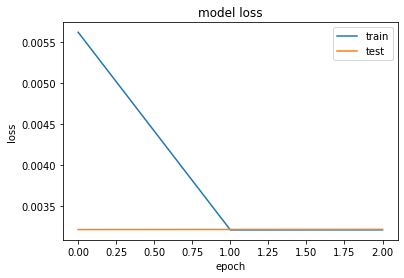

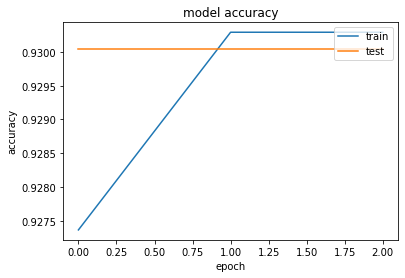

In [44]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [46]:
#get the MSE or loss error term
predictions = autoencoder.predict(vec_seqs)
mse = np.mean(np.power(vec_seqs - predictions, 2), axis=1)
sequences['MSE'] = mse

In [47]:
print('Loss 0.99:', np.quantile(mse, 0.99)) # => the 99% quatile - only 1% have error score higher than that
print('Loss 0.95:', np.quantile(mse, 0.95)) 
print('Loss 0.9:', np.quantile(mse, 0.9)) 
print('Loss 0.85:', np.quantile(mse, 0.85)) 
print('Loss 0.75:', np.quantile(mse, 0.75)) 
print('Loss 0.5:', np.quantile(mse, 0.5)) 

Loss 0.99: 0.006814774048282952
Loss 0.95: 0.006814774048282952
Loss 0.9: 0.004837478887989374
Loss 0.85: 0.003983701459521305
Loss 0.75: 0.0034686230937185404
Loss 0.5: 0.0032364443758669016


In [49]:

def get_sequence_anomaly_rank(seq_a):
    
    t_vec = tokenizer.texts_to_sequences([seq_a])
    
    pad_seq = pad_sequences(t_vec, maxlen=MAX_FEAT_LEN, padding='post', truncating='post')
    vec_seq = vectorize_sequences(pad_seq, VOCAB_SIZE)
    pred_seq = autoencoder.predict(vec_seq)
    # get anomaly score
    score = np.mean(np.power(vec_seq - pred_seq, 2), axis=1)
    # get anomaly rank
    rank =  stats.percentileofscore(mse, score)
    return score, rank

score, rank = get_sequence_anomaly_rank('9 20 649 20E04504A')
print(f'Anomaly Score:{score}, Percentile Rank:{rank}')

score, rank = get_sequence_anomaly_rank('9 30 399 30E04170A')
print(f'Anomaly Score:{score}, Percentile Rank:{rank}')


Anomaly Score:[0.00346862], Percentile Rank:73.85446487442933
Anomaly Score:[0.0022789], Percentile Rank:26.15471609925467


In [ ]:
def calculate_anomaly_score(df, seq_feat_name, freq_feat_name):
    
    tokenized_seq = tokenizer.texts_to_sequences(df[seq_feat_name].values)
    pad_seq = pad_sequences(tokenized_seq, maxlen=MAX_FEAT_LEN, padding='post', truncating='post')
    vec_seq = vectorize_sequences(pad_seq, VOCAB_SIZE)
    pred_seq = autoencoder.predict(vec_seq)
    dist = np.mean(np.power(vec_seq - pred_seq, 2), axis=1)
    df['dist'] = dist
    df['w_score'] = df[freq_feat_name] * df['dist']
    sum_score = df['w_score'].sum() / df[freq_feat_name].sum()
    return sum_score, df